In [41]:
import numpy as np
from PIL import Image
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

def load_data(file_path):
    if file_path.endswith('.csv'):
        # Load CSV file as intensity matrix and convert to NumPy array
        intensity_matrix = np.loadtxt(file_path, delimiter=',')
    else:
        image = Image.open('Pelican_pic.jpg').convert('L')
        intensity_matrix = np.array(image)
    
    return intensity_matrix

def create_neighbor_similarity_network(arr, sigma):
    rows, cols = arr.shape
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c), intensity=arr[r, c])

    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    for r in range(rows):
        for c in range(cols):
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    I_i = arr[r, c]
                    I_j = arr[nr, nc]
                    similarity = 100 * np.exp(-((I_i - I_j)**2) / (2 * sigma**2))
                    G.add_edge((r, c), (nr, nc), capacity=similarity)

    min_pixel = np.unravel_index(np.argmin(arr), arr.shape)
    max_pixel = np.unravel_index(np.argmax(arr), arr.shape)

    source_node = 'source'
    sink_node = 'sink'
    G.add_node(source_node)
    G.add_node(sink_node)

    G.add_edge(source_node, min_pixel, capacity=100)
    G.add_edge(max_pixel, sink_node, capacity=100)

    return G, source_node, sink_node

def solve_max_flow_undirected(G, source, sink):
    DG = G.to_directed()
    m = gp.Model()
    m.Params.LogToConsole = 0

    flow = m.addVars(G.edges(), lb=0, ub={(u, v): DG[u][v]['capacity'] for u, v in DG.edges()}, name="flow")

    for u, v in G.edges():
        capacity = G[u][v]['capacity']
        m.addConstr(flow[u, v] <= capacity, name=f"cap_{u}_{v}_pos")
        m.addConstr(-flow[u, v] <= capacity, name=f"cap_{u}_{v}_neg")

    net_flow = gp.quicksum(flow[source, neighbor] for neighbor in G.neighbors(source) if (source, neighbor) in flow)
    net_flow -= gp.quicksum(flow[neighbor, source] for neighbor in G.neighbors(source) if (neighbor, source) in flow)
    m.setObjective(net_flow, GRB.MAXIMIZE)

    for node in G.nodes():
        if node == source or node == sink:
            continue
        inflow = gp.quicksum(flow[neighbor, node] for neighbor in G.neighbors(node) if (neighbor, node) in flow)
        outflow = gp.quicksum(flow[node, neighbor] for neighbor in G.neighbors(node) if (node, neighbor) in flow)
        m.addConstr(inflow - outflow == 0, name=f"flow_conservation_{node}")

    m.optimize()

    return m, flow

def build_residual_network_undirected(G, flow_values):
    residual_G = nx.Graph()
    for u, v in G.edges():
        capacity = G[u][v]['capacity']
        flow_uv = flow_values[u, v]

        residual_capacity_uv = capacity - max(flow_uv, 0)
        residual_capacity_vu = capacity + min(flow_uv, 0)

        if residual_capacity_uv > 1e-6:
            residual_G.add_edge(u, v, capacity=residual_capacity_uv)
        if residual_capacity_vu > 1e-6:
            residual_G.add_edge(v, u, capacity=residual_capacity_vu)
    return residual_G

def get_accessible_nodes(residual_G, source):
    visited = set()
    stack = [source]
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            for neighbor in residual_G.neighbors(node):
                if neighbor not in visited:
                    stack.append(neighbor)
    return visited

def get_min_cut_edges_undirected(G, accessible_nodes):
    cut_edges = []
    for u in accessible_nodes:
        for v in G.neighbors(u):
            if v not in accessible_nodes:
                cut_edges.append((u, v))
    return cut_edges

def plot_cuts_on_image(arr, cut_edges):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 8))
    plt.imshow(arr, cmap='gray', interpolation='none')
    ax = plt.gca()

    for u, v in cut_edges:
        if isinstance(u, tuple) and isinstance(v, tuple):
            y1, x1 = u
            y2, x2 = v

            if y1 == y2:
                # Horizontal neighbors, vertical cut between them
                x_cut = (x1 + x2) / 2
                y_cut_start = y1 - 0.5
                y_cut_end = y1 + 0.5
                ax.plot([x_cut, x_cut], [y_cut_start, y_cut_end], color='red', linewidth=2)
            elif x1 == x2:
                # Vertical neighbors, horizontal cut between them
                y_cut = (y1 + y2) / 2
                x_cut_start = x1 - 0.5
                x_cut_end = x1 + 0.5
                ax.plot([x_cut_start, x_cut_end], [y_cut, y_cut], color='red', linewidth=2)

    plt.title('Min-Cut Edges')
    #plt.gca().invert_yaxis()
    plt.show()


# Main script
def main(filename, sig):
    arr = np.loadtxt(filename, delimiter=',')
    # arr = load_data(filename)
    sigma = sig
    G, source_node, sink_node = create_neighbor_similarity_network(arr, sigma)

    m, flow = solve_max_flow_undirected(G, source_node, sink_node)

    if m.status == GRB.OPTIMAL:
        flow_values = m.getAttr('x', flow)
        residual_G = build_residual_network_undirected(G, flow_values)
        accessible_nodes = get_accessible_nodes(residual_G, source_node)
        cut_edges = get_min_cut_edges_undirected(G, accessible_nodes)
        plot_cuts_on_image(arr, cut_edges)
    else:
        print("Optimal solution was not found.")


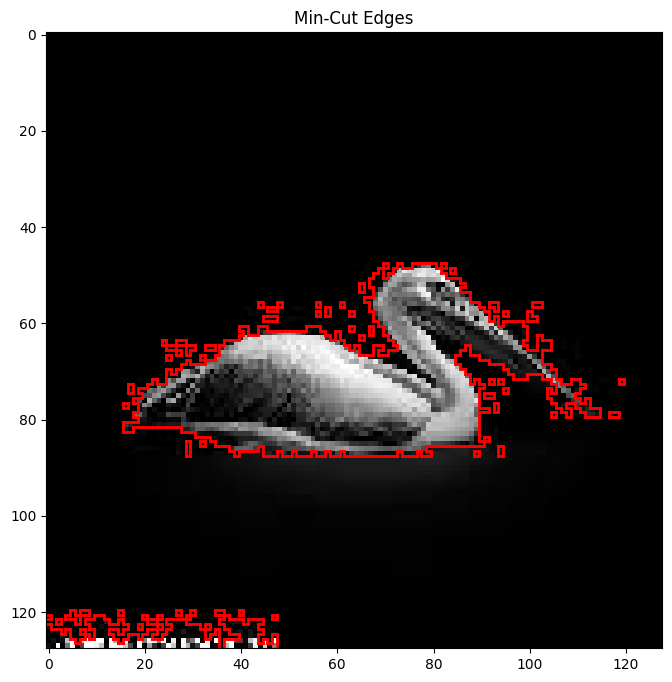

In [43]:
# main('box.csv', 0.01)
# main('oval.csv',0.05)
main('swan.jpg',0.8)
# main('bird2_down.jpg',0.2)
# main('bird3_down.jpg',0.05)
# main('bird4_down.jpg',0.01)